In [3]:
import numpy as np
import re
from collections import Counter
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt

In [17]:
train_pos = "hotelPosT-train-Copy1.txt"
train_neg = "hotelNegT-train-Copy1.txt"

### Get word counts

In [18]:
def count_words(txt_file):
    '''
    Join all the reviews in a file and count occurences of each unigram.
    '''
    with open(txt_file, "r") as infile:
        reviews = infile.readlines()
    
    count_r = 0
    split_reviews = []
    for r in reviews:    
        count_r += 1
        review = re.sub("[,.!?]", "", r)
        review = review.lower().split()
        split_reviews += review[1:]
        
    return split_reviews, Counter(split_reviews), count_r

words_list_pos, word_counts_pos, review_count_pos = count_words(train_pos)
words_list_neg, word_counts_neg, review_count_neg = count_words(train_neg)

In [126]:
review_count_pos, review_count_neg

(92, 91)

In [131]:
# For smoothing later: size of set of unique words
V = len(set(words_list_neg+words_list_pos))
V

3172

In [19]:
count_pos = len(words_list_pos)
count_neg = len(words_list_neg)
total_words = count_pos + count_neg
len(words_list_pos), len(words_list_neg), total_words

(10756, 10904, 21660)

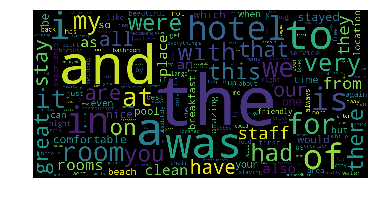

In [20]:
wordcloud1 = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_counts_pos)
plt.imshow(wordcloud1); plt.axis("off"); plt.show()

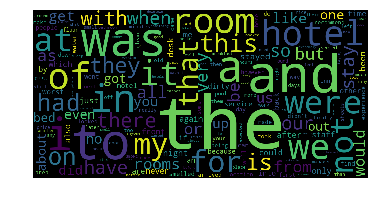

In [21]:
wordcloud2 = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_counts_neg)
plt.imshow(wordcloud2); plt.axis("off"); plt.show()

For a given review, each word is an input feature (i.e. $x_i$): <br>

$$ P(y|x_1,...,x_n) = \frac{P(y) \prod_{i=1}^{n} P(x_i|y)}{P(x_1,...,x_n)} $$

For each review:
1. Split text into unigrams
2. Get $P(y)$ - total number of words in a review type / total number of words
3. Get $P(x_i|y)$ - number of each word in review / total number of words in a review type
4. Multiple 2 and 3.

### Calculate probabilities

In [118]:
test_review = "ID-1210	Went to this hotel when visiting nearby national parks with family. Front desk staff was courteous and quickly resolved any questions we had. Our 2-queen bed room was clean and spacious. Room has nice LCD TV, coffee maker, fridge, microwave, massaging shower heads, and good mattresses. We stayed for 2 nights and room was well cleaned and put together after first night with coffee packs refilled. Overall very satisfied."
test_review = re.sub("[,.!]", "", test_review)
test_review = test_review.lower().split()


In [128]:
# These are P(class): FIX: count(id's in a class / total id's)
# prob_pos = count_pos / total_words
# prob_neg = count_neg / total_words
prob_pos = review_count_pos / (review_count_pos + review_count_neg)
prob_neg = review_count_neg / (review_count_pos + review_count_neg)
prob_pos, prob_neg

(0.5027322404371585, 0.4972677595628415)

In [129]:
count_pos, count_neg

(10756, 10904)

In [147]:
def predict_class(review, class_prob, class_count, V, word_counts):
#     prediction = 1
    prediction = 0
    for word in review[1:]:
        # Compute conditional prob
        word_count = word_counts[word] + 1
#         prob_word_given_class = (word_count) / (class_count + V)
#         print("prob: " + str(prob_word_given_class))
#         print(prediction)


        # Try log space:
        prob_word_given_class = np.log((word_count) / (class_count + V))
        prediction += prob_word_given_class
#         prediction *= prob_word_given_class

#         print(prediction)
    return prediction + np.log(class_prob)

pos = predict_class(test_review, prob_pos, count_pos, V, word_counts_pos)
neg = predict_class(test_review, prob_neg, count_neg, V, word_counts_neg)
pos, neg, pos > neg

(-472.7495798955193, -472.8026386170834, True)

In [135]:
count_pos

10756

In [148]:
def make_decision(review, predict_class):
    # Compute probabilities for positive and negative classes
    predict_pos = predict_class(review, prob_pos, count_pos, review_count_pos, word_counts_pos)
    predict_neg = predict_class(review, prob_neg, count_neg, review_count_neg, word_counts_neg)
    
    if predict_pos > predict_neg:
        return "POS"
    elif predict_pos < predict_neg:
        return "NEG"
    else:
        return "ERROR SOMEWHERE!!"

make_decision(test_review, predict_class)

'POS'

In [149]:
# Read test file and output class
test_file = "test.txt"
with open(test_file, 'r') as test:
    test = test.readlines()
    
for line in test:
    review = re.sub("[,.!]", "", line)
    review = review.lower().split()
    review_id = review[0]
    print(make_decision(review, predict_class))

POS
NEG
POS
NEG
POS
NEG
